## Introduction

Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries insurance it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

Knowing all of this, On the Road car insurance have requested our services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked our team to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

They have supplied us with their encoded customer data as a csv file, along with a table detailing the column names and descriptions below.

---
### The Dataset

We will use the provided `car_insurance.csv` in our analysis process. For this dataset, we can find that info [here](/images/Data%20Dictionary.png).



### Dataset dictionary

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-15</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme()

## 1. Load and read the dataset

In [2]:
# Load the csv file into a dataframe named 'insurance_df'
insurance_df = pd.read_csv(r'data/car_insurance.csv')

# View the head of the dataframe
insurance_df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## 2. Data cleaning

In [3]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

The dataset has 10000 rows and 17 columns. There are 5 categorical columns and 12 numerical columns.

There are 2 columns 'credit_score' and 'annual_milage' with missing values. These 2 columns are important in determning an auto insurance claim, so we'll make sure to fill in those missing values.

In [4]:
# Summary statistics of numerical columns
insurance_df.describe()

,id,age,gender,credit_score,vehicle_ownership,married,children,postal_code,annual_mileage,speeding_violations,duis,past_accidents,outcome
count,10000.000000,10000.000000,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,1.489500,0.499000,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,1.025278,0.500024,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.000000,0.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,1.000000,0.000000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,1.000000,0.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,2.000000,1.000000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,3.000000,1.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


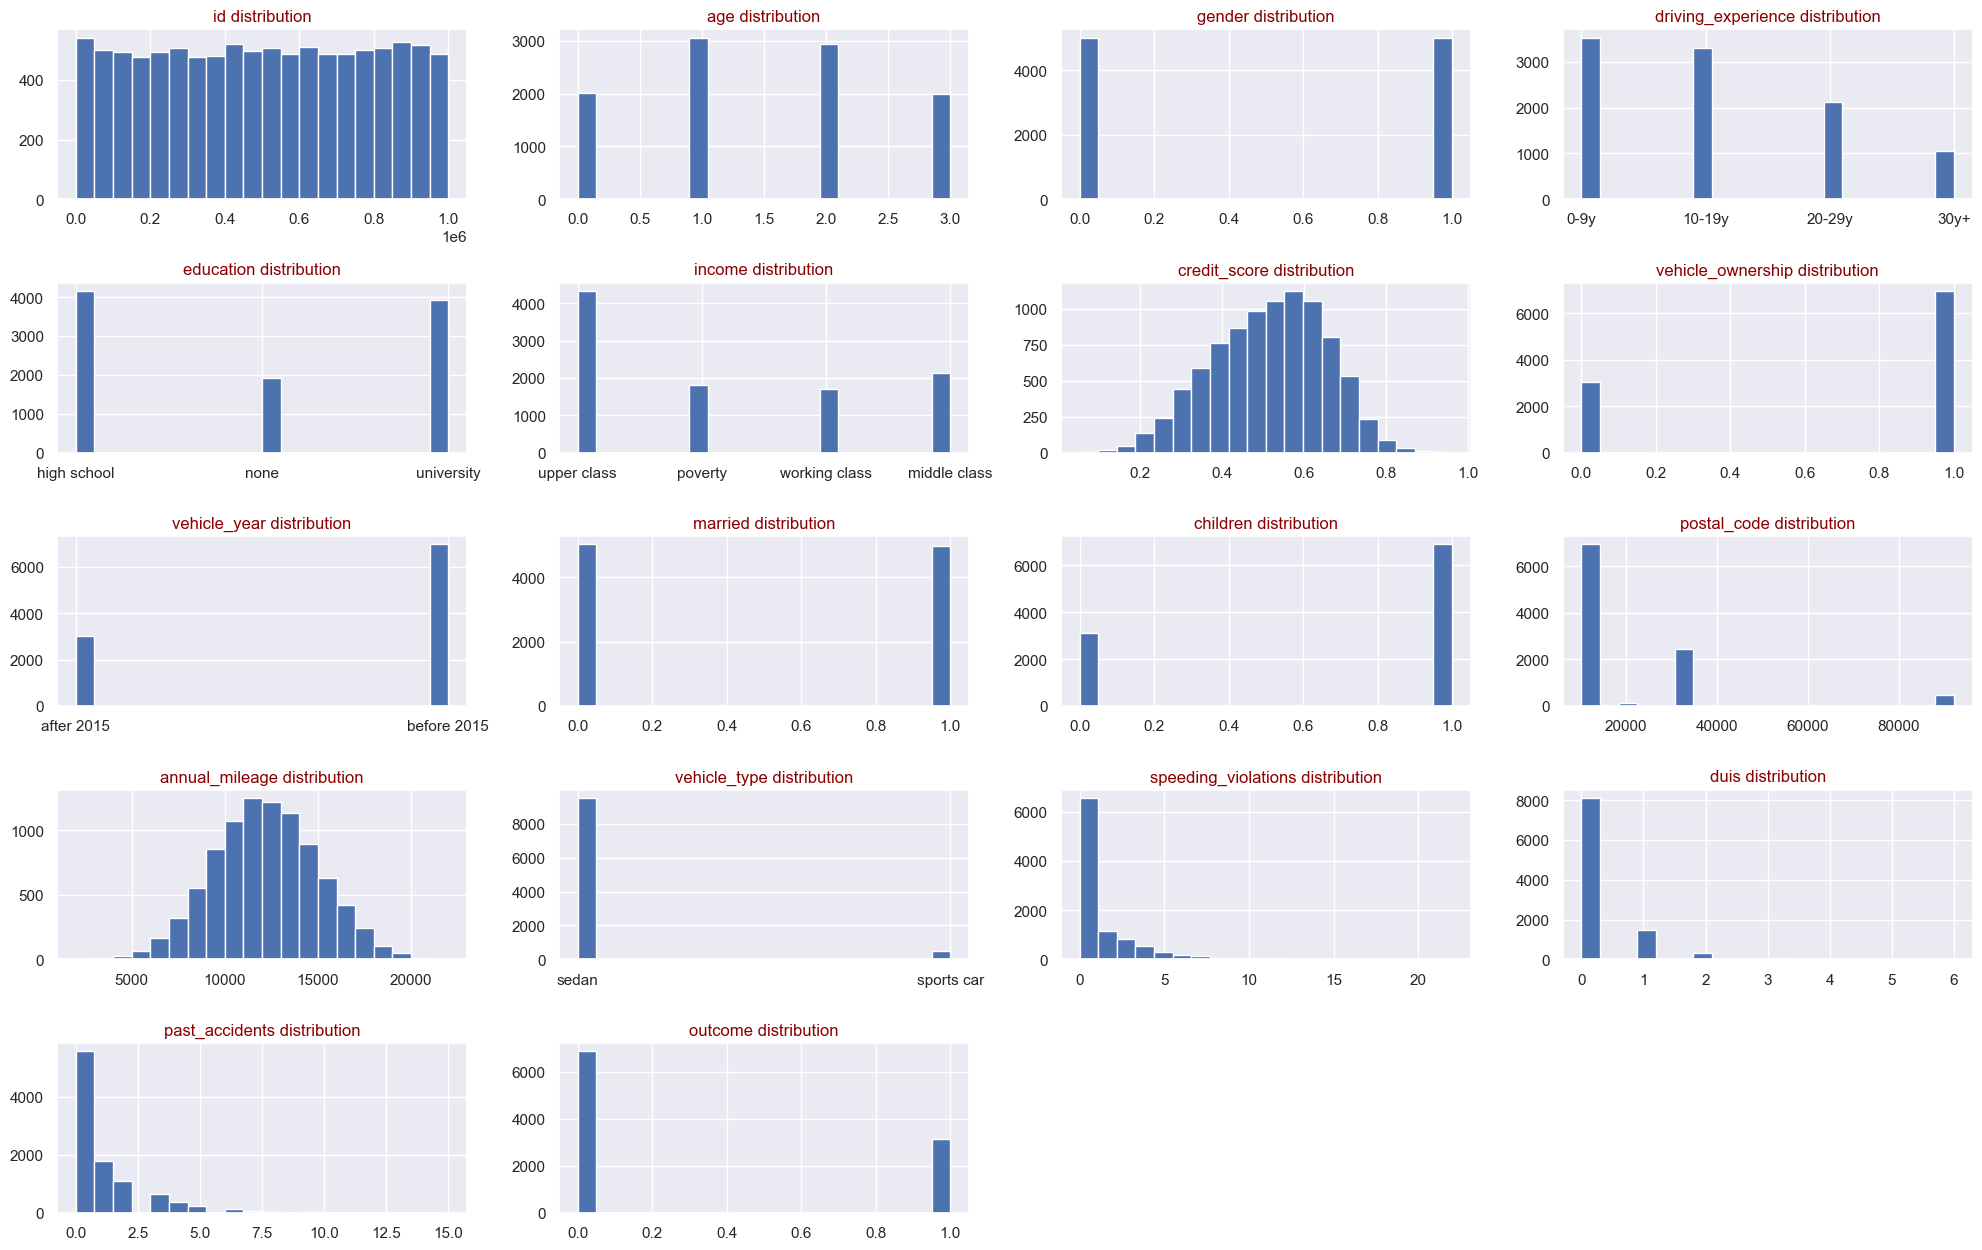

In [5]:
# Plot histogram all columns
def draw_histograms(dataframe, features, rows, cols):
    
    fig = plt.figure(figsize=(20,20))

    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax)
        ax.set_title(feature+' distribution', color='darkRed')
    
    fig.tight_layout()
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

draw_histograms(insurance_df, insurance_df.columns, 8, 4)

* **Handle missing values:**

In [6]:
insurance_df.isnull().sum()

id                       0
age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis                     0
past_accidents           0
outcome                  0
dtype: int64

In [7]:
# Create a copy of the insurance_df dataframe to test if imputing missing values in those 2 important columns will work or not
insurance_df_copy = insurance_df.copy()

In [8]:
# The distribution of 'credit_score' looks a bit left skewed, fill in the null values here with the median value
insurance_df_copy['credit_score'] = insurance_df_copy['credit_score'].fillna((insurance_df_copy['credit_score'].median()))

# Check if the missing values are treated
insurance_df_copy['credit_score'].isnull().sum()

0

In [9]:
# The distribution of 'annual_mileage' looks resembling a normal distribution, fill in the null values here with the mean value
insurance_df_copy['annual_mileage'] = insurance_df_copy['annual_mileage'].fillna((insurance_df_copy['annual_mileage'].mean()))

# Check if the missing values are treated
insurance_df_copy['annual_mileage'].isnull().sum()

0

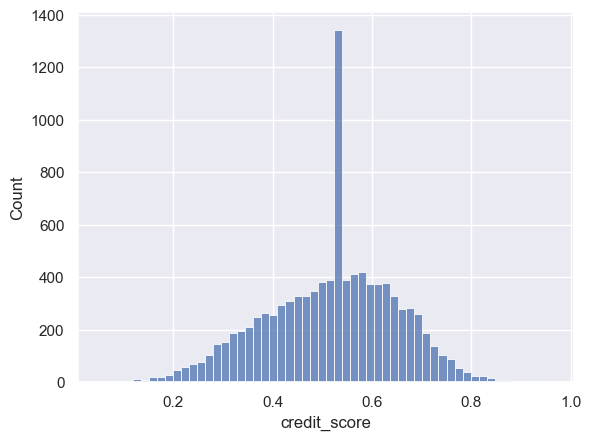

In [10]:
# Plot the 'credit_score' column if we were to fill in the null values with the median
# May not be a good idea to use the median or mean to fill in missing values, as they'll distort the distribution
sns.histplot(data=insurance_df_copy, x='credit_score')
plt.show()

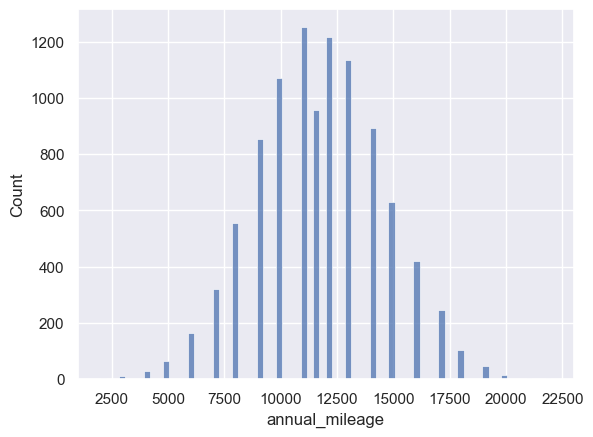

In [11]:
# Plot the 'annual_mileage' column if we were to fill in the null values with the mean
# May not be a good idea to use the median or mean to fill in missing values, as they'll distort the distribution 
sns.histplot(data=insurance_df_copy, x='annual_mileage')
plt.show()

In [12]:
# Let's just drop the rows with missing values
insurance_df.dropna(subset=['credit_score', 'annual_mileage'], inplace=True)
insurance_df.isnull().sum()

id                     0
age                    0
gender                 0
driving_experience     0
education              0
income                 0
credit_score           0
vehicle_ownership      0
vehicle_year           0
married                0
children               0
postal_code            0
annual_mileage         0
vehicle_type           0
speeding_violations    0
duis                   0
past_accidents         0
outcome                0
dtype: int64

In [13]:
# Delete the test insurance_df_copy dataframe
del insurance_df_copy

* **Check for duplication:**

In [14]:
insurance_df.duplicated().value_counts()

False    8149
dtype: int64

In [15]:
# Check if duplicates in the 'id' column
id_unique = len(set(insurance_df.id))
id_total = insurance_df.shape[0]
id_dup = id_unique - id_total

print(id_dup)

0


* **Encode categorical columns with 'object' datatype:**

In [16]:
# Create a copy dataframe with just object data type
obj_df = insurance_df.select_dtypes(include=['object']).copy()
obj_df.head()

,driving_experience,education,income,vehicle_year,vehicle_type
0,0-9y,high school,upper class,after 2015,sedan
1,0-9y,none,poverty,before 2015,sedan
2,0-9y,high school,working class,before 2015,sedan
3,0-9y,university,working class,before 2015,sedan
4,10-19y,none,working class,before 2015,sedan


In [17]:
# Check unique values of 'driving_experience'
obj_df['driving_experience'].value_counts()

0-9y      2864
10-19y    2662
20-29y    1756
30y+       867
Name: driving_experience, dtype: int64

In [18]:
# Check unique values of 'education'
obj_df['education'].value_counts()

high school    3404
university     3217
none           1528
Name: education, dtype: int64

In [19]:
# Check unique values of 'income'
obj_df['income'].value_counts()

upper class      3588
middle class     1727
poverty          1459
working class    1375
Name: income, dtype: int64

In [20]:
# Check unique values of 'vehicle_year'
obj_df['vehicle_year'].value_counts()

before 2015    5642
after 2015     2507
Name: vehicle_year, dtype: int64

In [21]:
# Check unique values of 'vehicle_type'
obj_df['vehicle_type'].value_counts()

sedan         7761
sports car     388
Name: vehicle_type, dtype: int64

In [22]:
cat_encode_dict = {"driving_experience": {"0-9y": 0, "10-19y": 1, "20-29y": 3, "30y+": 4},
                   "education": {"none": 0, "high school": 1, "university": 2},
                   "income": {"poverty": 0, "working class": 1, "upper class": 2, "middle class": 3},
                   "vehicle_year": {"before 2015": 0, "after 2015": 1},
                   "vehicle_type": {"sedan": 0, "sports car": 1}
                   }

obj_df = obj_df.replace(cat_encode_dict)
obj_df

,driving_experience,education,income,vehicle_year,vehicle_type
0,0,1,2,1,0
1,0,0,0,0,0
2,0,1,1,0,0
3,0,2,1,0,0
4,1,0,1,0,0
...,...,...,...,...,...
9994,1,1,3,0,0
9995,1,2,2,0,0
9997,0,1,3,0,0
9998,1,1,0,0,0


In [23]:
# Reassign those encoded values from the 'obj_df' dataframe back to insurance_df
insurance_df[obj_df.columns] = obj_df
insurance_df

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0,1,2,0.629027,1.0,1,0.0,1.0,10238,12000.0,0,0,0,0,0.0
1,750365,0,1,0,0,0,0.357757,0.0,0,0.0,0.0,10238,16000.0,0,0,0,0,1.0
2,199901,0,0,0,1,1,0.493146,1.0,0,0.0,0.0,10238,11000.0,0,0,0,0,0.0
3,478866,0,1,0,2,1,0.206013,1.0,0,0.0,1.0,32765,11000.0,0,0,0,0,0.0
4,731664,1,1,1,0,1,0.388366,1.0,0,0.0,0.0,32765,12000.0,0,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,752887,1,1,1,1,3,0.454300,1.0,0,0.0,0.0,10238,16000.0,0,1,0,2,0.0
9995,323164,1,0,1,2,2,0.582787,1.0,0,0.0,0.0,10238,16000.0,0,0,0,1,0.0
9997,468409,1,1,0,1,3,0.470940,1.0,0,0.0,1.0,10238,14000.0,0,0,0,0,0.0
9998,903459,1,0,1,1,0,0.364185,0.0,0,0.0,1.0,10238,13000.0,0,2,0,1,1.0


* **Detect outliers in some numerical columns need further investigation:**

In [24]:
numeric_cols = insurance_df[['credit_score', 'annual_mileage', 'speeding_violations', 'duis', 'past_accidents']]

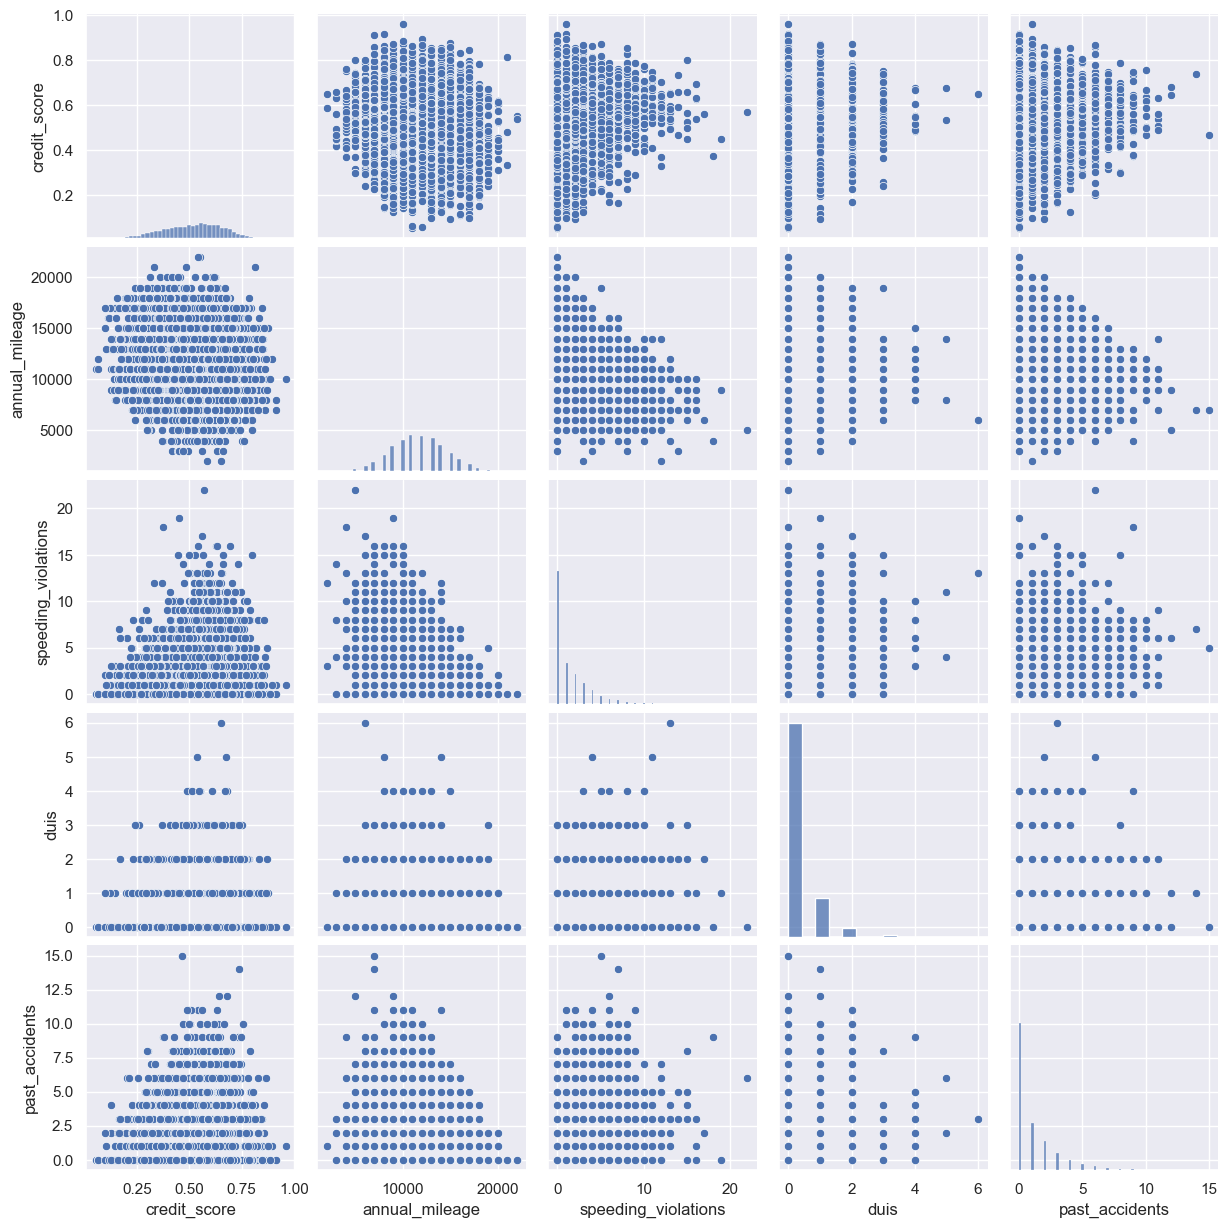

In [25]:
# Plot the suspected columns with outliers to see pairwise relationships betwwen them
sns.pairplot(numeric_cols)
plt.show()

We do have some outliers across our suspected columns but there also doesn't seem to have a linear relationship between them. As we're not sure about determining the trend line to best fit them, let's leave them as is. Note that the spreads of 'credit_score' and 'annual_mileage' are very far from the center, we might need to scale the data later on.

## 3. Exploratory and statistical data analysis

### Hypothesis Tests

* Kolmogorov-Smirnov's test for normality on numerical columns: Reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.

In [26]:
# For N>5000 the shapiro W test statistic is accurate, but the p-value may not be (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
# We'll use the Kolmogorov-Smirnov test 
for col in numeric_cols:
    stat, p = kstest(insurance_df[col], 'norm')
    print(col, ':', '%0.30f' % p)

credit_score : 0.000000000000000000000000000000
annual_mileage : 0.000000000000000000000000000000
speeding_violations : 0.000000000000000000000000000000
duis : 0.000000000000000000000000000000
past_accidents : 0.000000000000000000000000000000


Since p-value<<0.05, we reject the null hypothesis. The data are not distributed according to the standard normal.

### Assumption Tests for Logistic Regression Model

We saw earlier in the data dictionary that the single feature used to predict whether a car insurance claim will be made or not is 'outcome'. It takes in `0`: No claim; and `1`: Made a claim. Logistic regression model might work well in this case with a binary dependent variable.

* **Test the assumption that the dependent variable 'outcome' is binary:**

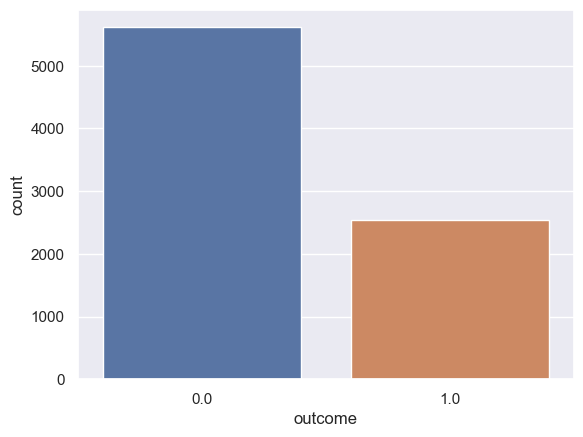

In [27]:
# Use sns countplot to visualize the binary dependent variable 'outcome'
sns.countplot(x='outcome', data=insurance_df)
plt.show()

* **Test the assumption that the continuous independent variables ('credit_score', 'annual_mileage') being linearly related to the log odds**:

    One way to do it is to plot the continuous independent variables in question and look for an S-shaped curve.

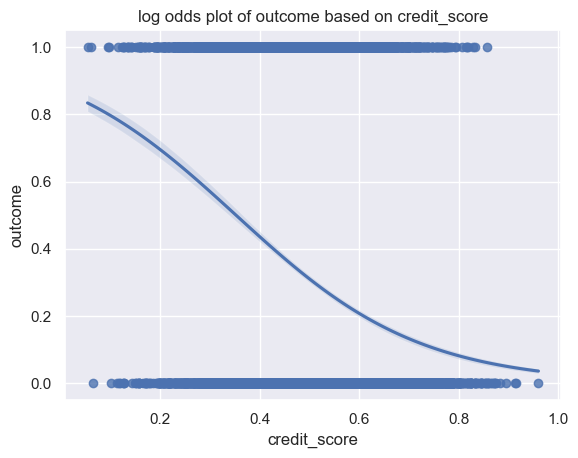

In [28]:
# Use Seaborn regplot to look for the S-shaped curve between 'credit_score' and 'outcome'
sns.regplot(x='credit_score', y='outcome', data=insurance_df, logistic= True).set_title("log odds plot of outcome based on credit_score")
plt.show()

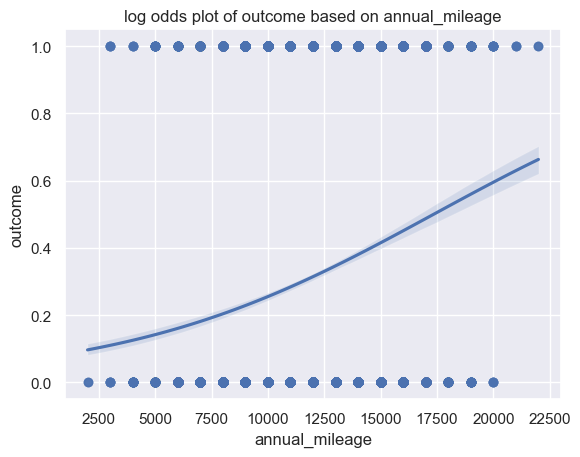

In [29]:
# Use Seaborn regplot to look for the S-shaped curve between 'annual_mileage' and 'outcome'
sns.regplot(x='annual_mileage', y='outcome', data=insurance_df, logistic= True).set_title("log odds plot of outcome based on annual_mileage")
plt.show()

Extra regplots to look for the S-shaped curve between some meaningful features and 'outcome':

The plots though show a rather flat S-shaped curved, so we can accept this assumption.

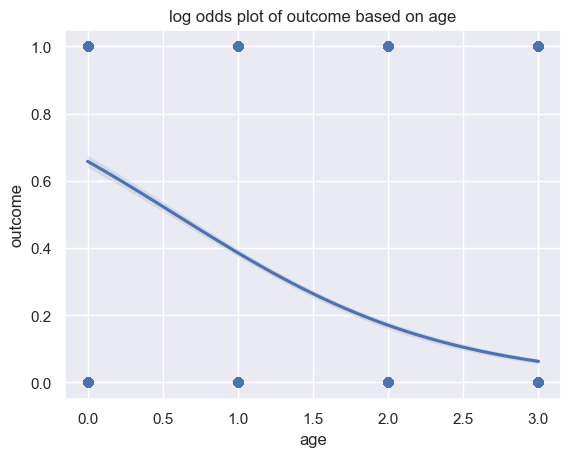

In [30]:
# Use Seaborn regplot to look for the S-shaped curve between 'age' and 'outcome'
sns.regplot(x='age', y='outcome', data=insurance_df, logistic= True).set_title("log odds plot of outcome based on age")
plt.show()

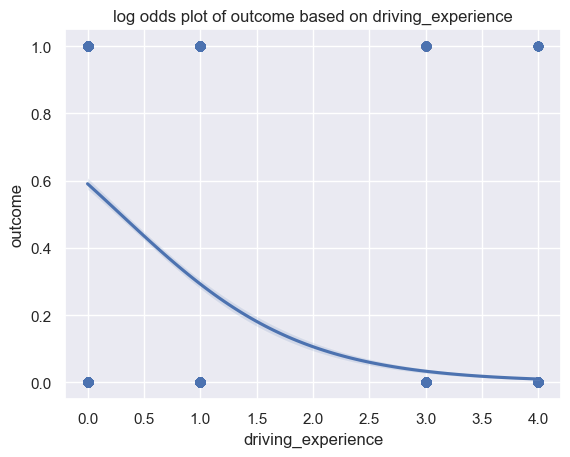

In [31]:
# Use Seaborn regplot to look for the S-shaped curve between 'driving_experience' and 'outcome'
sns.regplot(x='driving_experience', y='outcome', data=insurance_df, logistic= True).set_title("log odds plot of outcome based on driving_experience")
plt.show()

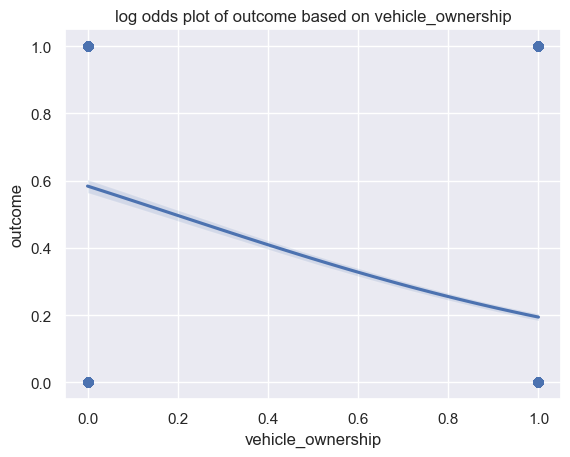

In [32]:
# Use Seaborn regplot to look for the S-shaped curve between 'vehicle_ownership' and 'outcome'
sns.regplot(x='vehicle_ownership', y='outcome', data=insurance_df, logistic= True).set_title("log odds plot of outcome based on vehicle_ownership")
plt.show()

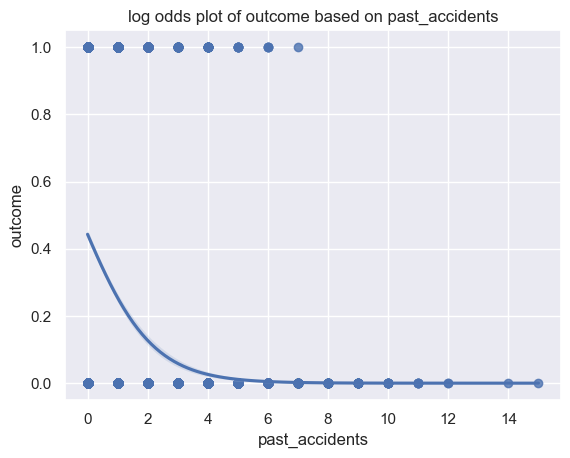

In [33]:
# Use Seaborn regplot to look for the S-shaped curve between 'past_accidents' and 'outcome'
sns.regplot(x='past_accidents', y='outcome', data=insurance_df, logistic= True).set_title("log odds plot of outcome based on past_accidents")
plt.show()

* **Test the assumption of independence between features and absence of multicollinearity:**

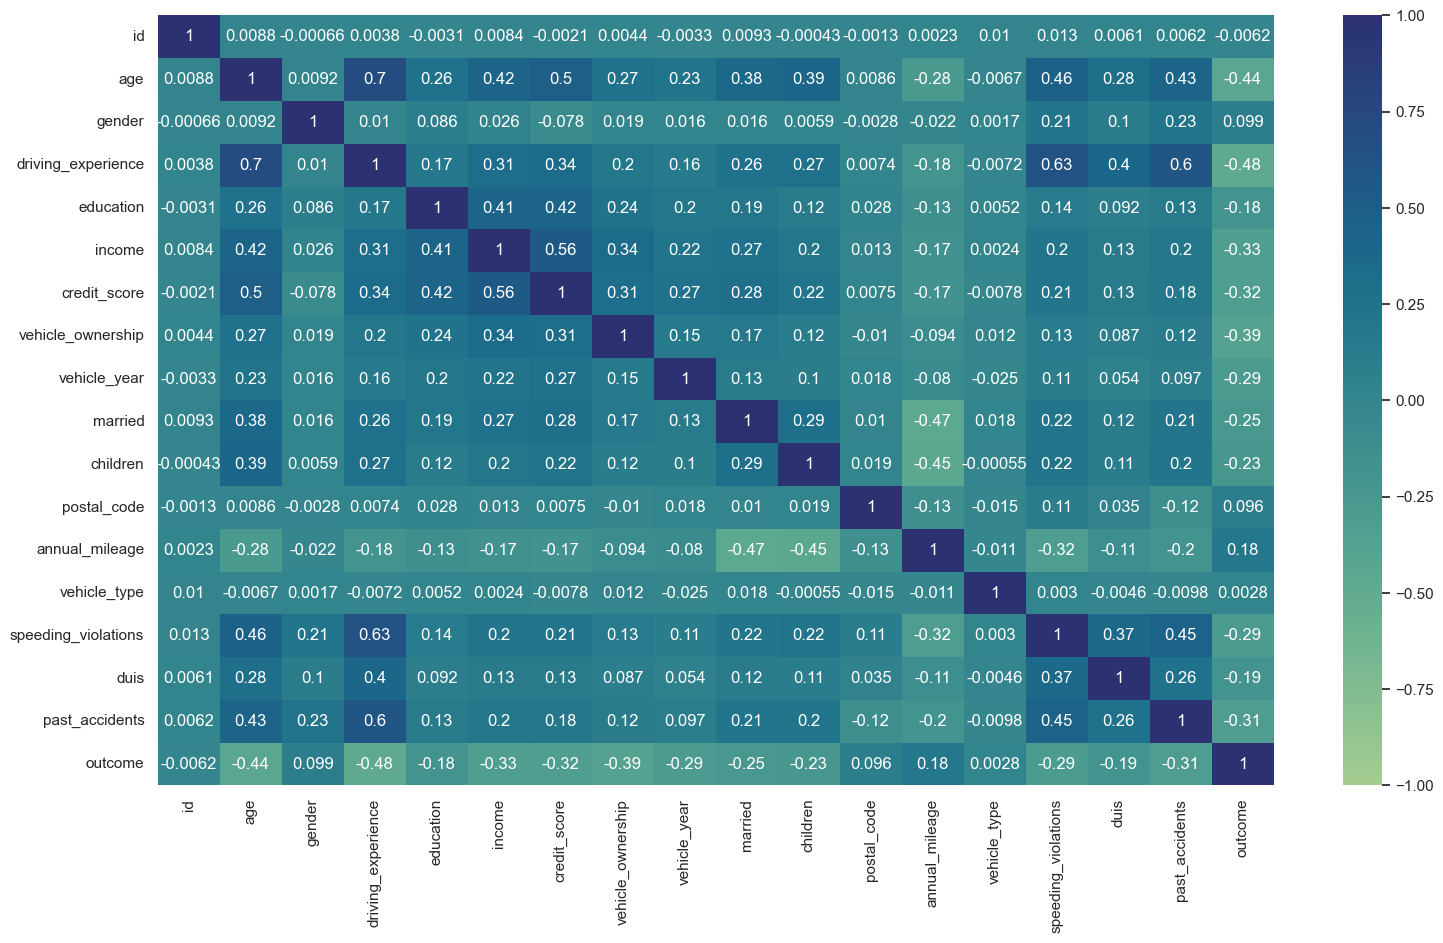

In [34]:
# Use a correlation matrix to check the relationship between those independent variables
plt.figure(figsize=(18, 10))
heatmap = sns.heatmap(insurance_df.corr(), vmin=-1, vmax=1, annot=True, cmap='crest')
plt.show()

We have so many features correlating with each other with the threshold is <-0.5 or >+0.5. For instance: 'driving_experience', 'credit_score' highly correlates with 'age'; same with 'speeding_violations', 'past_accidents' and 'driving_experience' and so on. 

Applying a Polynomial Logistics Regression model using all these features will not satisfy the assumption that: 1) The observations to be independent of each other, 2) There's little or no multicollinearity among the independent variables. 

We can consider a loop to build a simple Logistics Regression model of each independent variable to determine the best fit model to predict the target variable in this case.

*  **Test the assumption that the dataset size is of a large sample size:**

In [35]:
insurance_df.shape

(8149, 18)

8149 rows is a sufficient dataset size for logistics regression.

### Scaling for numeric columns

We are using Logistic Regression as our model, it's beneficial to scale the features, especially if they're on vastly different scales. Logistic Regression isn't a distance-based method, but it does involve optimization to find the best coefficients for the model. Feature scaling helps these optimization algorithms converge more quickly and effectively. we'll just use StandardScaler for numerical variables.

In [36]:
# Recall the 'numeric_cols' dataframe we have before
numeric_cols

,credit_score,annual_mileage,speeding_violations,duis,past_accidents
0,0.629027,12000.0,0,0,0
1,0.357757,16000.0,0,0,0
2,0.493146,11000.0,0,0,0
3,0.206013,11000.0,0,0,0
4,0.388366,12000.0,2,0,1
...,...,...,...,...,...
9994,0.454300,16000.0,1,0,2
9995,0.582787,16000.0,0,0,1
9997,0.470940,14000.0,0,0,0
9998,0.364185,13000.0,2,0,1


In [37]:
# Create a scaler object
scaler = StandardScaler()

# Fit and transform the numerical columns
insurance_df[numeric_cols.columns] = scaler.fit_transform(insurance_df[numeric_cols.columns])

## 4. Logistic Regression Model

In [38]:
# Create an empty list called models to store each model object created
models = []

# # Create an empty list called result to store the result of each model object created
# results = []

# Store all indpendent columns as a variable 'features', except for 'id' and 'outcome'
features = insurance_df.columns.drop(['id', 'outcome'])

In [39]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(insurance_df[features], insurance_df['outcome'], test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(6519, 16)
(1630, 16)
(6519,)
(1630,)


In [40]:
# Loop through each col in 'features' and build a simple Logistic Regression model for each col
for col in features:

    # Reshape the train dataset
    train = np.array(X_train[col]).reshape(-1,1)
    y_train = np.array(y_train).reshape(-1,1)

    # Create a logistic regression model
    # Increase the number of iterations and specify a solver that works with larger datasets
    model = LogisticRegression(max_iter=100, solver='liblinear') 
    
    # Fit the model to the training data
    model.fit(train, y_train)

    # Add the trained model to the list
    models.append((col, model))

In [41]:
models

[('age', LogisticRegression(solver='liblinear')),
 ('gender', LogisticRegression(solver='liblinear')),
 ('driving_experience', LogisticRegression(solver='liblinear')),
 ('education', LogisticRegression(solver='liblinear')),
 ('income', LogisticRegression(solver='liblinear')),
 ('credit_score', LogisticRegression(solver='liblinear')),
 ('vehicle_ownership', LogisticRegression(solver='liblinear')),
 ('vehicle_year', LogisticRegression(solver='liblinear')),
 ('married', LogisticRegression(solver='liblinear')),
 ('children', LogisticRegression(solver='liblinear')),
 ('postal_code', LogisticRegression(solver='liblinear')),
 ('annual_mileage', LogisticRegression(solver='liblinear')),
 ('vehicle_type', LogisticRegression(solver='liblinear')),
 ('speeding_violations', LogisticRegression(solver='liblinear')),
 ('duis', LogisticRegression(solver='liblinear')),
 ('past_accidents', LogisticRegression(solver='liblinear'))]

### Logistic Regression Model Evaluation

In [42]:
from sklearn.metrics import accuracy_score

for col, model in models:

    # Reshape X_test
    test = np.array(X_test[col]).reshape(-1,1)

    # Make predictions on the test data
    y_pred = model.predict(test)

    # Reshape y_test and y_pred
    y_pred = np.array(y_pred).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    print(col, accuracy)


age 0.7779141104294478
gender 0.6852760736196319
driving_experience 0.7711656441717791
education 0.6852760736196319
income 0.7521472392638037
credit_score 0.7147239263803681
vehicle_ownership 0.743558282208589
vehicle_year 0.6852760736196319
married 0.6852760736196319
children 0.6852760736196319
postal_code 0.6852760736196319
annual_mileage 0.6920245398773006
vehicle_type 0.6852760736196319
speeding_violations 0.6852760736196319
duis 0.6852760736196319
past_accidents 0.6852760736196319


We will use the accuracy score as our main machine learning classification model performance metric to compare the performance of each simple logistic regression model of each independent variable in the for loop above. Accuracy score is calculated by the ratio of sum of true positive and true negatives out of all the predictions made. 

In other words, accuracy tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made the predictions.

Among our predicted model with each feature, 'age' and 'driving_experience' have the the highest accuracy score of respectively: age: 0.7779141104294478, driving_experience: 0.7711656441717791. We might conclude that there are two best candidate models to predict whether a customer will make a claim on their insurance during the policy period, with 'age' having a slightly better accuracy than 'driving_experience'.


In [43]:
# Initialize age_model and driving_experience_model as None
age_model = None
driving_experience_model = None

# Loop through each col in 'features' and find the logistic regression models for 'age' and 'driving_experience'
for col, model in models:
    if col == 'age':
        age_model = model
        print("The age_model has the coeff and the intercept as:", age_model.coef_, age_model.intercept_)
    elif col == 'driving_experience':
        driving_experience_model = model
        print("The driving_experience_model has the coeff and the intercept as:", driving_experience_model.coef_, driving_experience_model.intercept_)

# Combine X_train and X_test for predictions
X = pd.concat([X_train, X_test])

# Get predictions for 'age' and 'driving_experience' from the combined dataset
y_pred_age = age_model.predict(X[['age']])
y_pred_driving_experience = driving_experience_model.predict(X[['driving_experience']])

The age_model has the coeff and the intercept as: [[-1.11448209]] [0.6438193]
The driving_experience_model has the coeff and the intercept as: [[-1.2841026]] [0.38132064]


The two candidate prediction models can now be presented in the sequence of more accuracy as follows:

1.
$$
p_{outcome} = \dfrac{1}{1+e^{-(0.6438193-1.11448209\times (age))}}
$$

2.
$$
p_{outcome} = \dfrac{1}{1+e^{-(0.38132064-1.2841026\times (driving\_experience))}}
$$

### Visualize predicted values of our two candidate predicted ML models:

In [44]:
# Create a copy of insurance_df to save the prediction values using 'age' or 'driving_experience'
insurance_df_pred = insurance_df.copy()

# Add predictions back to the dataframe
insurance_df_pred['outcome_pred_age'] = y_pred_age
insurance_df_pred['outcome_pred_driving_experience'] = y_pred_driving_experience

In [45]:
# View the new dataframe with two predicted outcome columns from our two candidate logistics regression models
insurance_df_pred

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome,outcome_pred_age,outcome_pred_driving_experience
0,569520,3,0,0,1,2,0.818297,1.0,1,0.0,1.0,10238,0.108618,0,-0.661855,-0.431964,-0.639757,0.0,0.0,0.0
1,750365,0,1,0,0,0,-1.152059,0.0,0,0.0,0.0,10238,1.525963,0,-0.661855,-0.431964,-0.639757,1.0,0.0,0.0
2,199901,0,0,0,1,1,-0.168671,1.0,0,0.0,0.0,10238,-0.245718,0,-0.661855,-0.431964,-0.639757,0.0,0.0,0.0
3,478866,0,1,0,2,1,-2.254245,1.0,0,0.0,1.0,32765,-0.245718,0,-0.661855,-0.431964,-0.639757,0.0,1.0,1.0
4,731664,1,1,1,0,1,-0.929734,1.0,0,0.0,0.0,32765,0.108618,0,0.229183,-0.431964,-0.039345,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,752887,1,1,1,1,3,-0.450822,1.0,0,0.0,0.0,10238,1.525963,0,-0.216336,-0.431964,0.561068,0.0,0.0,1.0
9995,323164,1,0,1,2,2,0.482433,1.0,0,0.0,0.0,10238,1.525963,0,-0.661855,-0.431964,-0.039345,0.0,0.0,0.0
9997,468409,1,1,0,1,3,-0.329960,1.0,0,0.0,1.0,10238,0.817291,0,-0.661855,-0.431964,-0.639757,0.0,1.0,1.0
9998,903459,1,0,1,1,0,-1.105372,0.0,0,0.0,1.0,10238,0.462955,0,0.229183,-0.431964,-0.039345,1.0,0.0,0.0


In [46]:
# Save the actual value of 'outcome' and 'outcome_pred_age', 'outcome_pred_driving_experience' to visualize
actual_pred = insurance_df_pred[['outcome', 'outcome_pred_age', 'outcome_pred_driving_experience']]

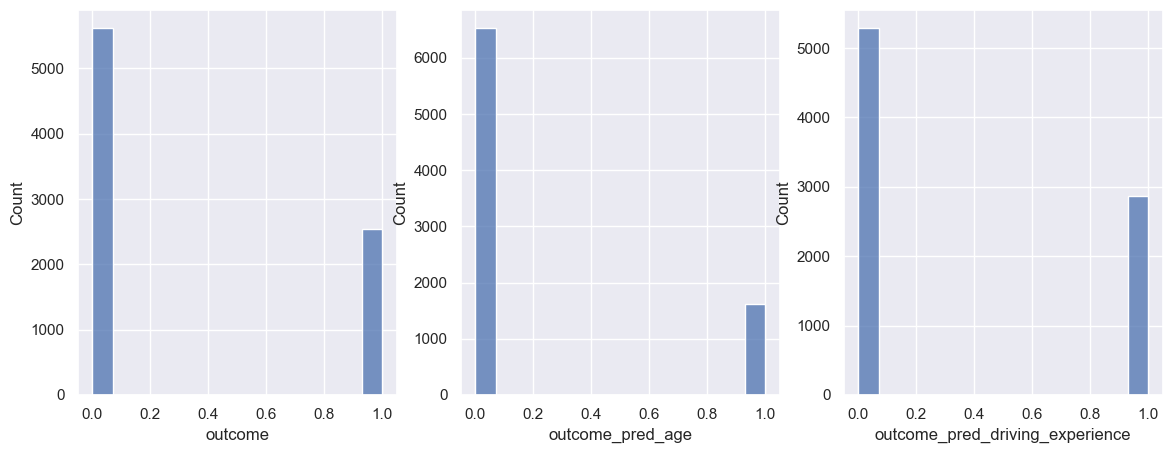

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Plot the actual and predicted values of 'outcome' by seaborn histogram
sns.histplot(ax=axes[0], data=actual_pred, x='outcome')
sns.histplot(ax=axes[1], data=actual_pred, x='outcome_pred_age')
sns.histplot(ax=axes[2], data=actual_pred, x='outcome_pred_driving_experience')

plt.show()

* **Business insights drawn from the prediction visualizations:**

In reality, the underlying theme of car insurance contracts are based on risk assumptions of how likely the insured will claim on the insurance to determine the rates charged. Our prediction visualization reveals an interesting finding that the accuracy score is not always the preferred metric to choose a machine learning model for business.

If everything's risk-based in this case, predicting more people claiming the auto insurance is better and less risky than predicting less than the actual number. Our company might prefer to use 'driving_experience' as the main predictor.

### Export the 'insurance_df_pred' dataframe to csv for dashboard building in Tableau

In [48]:
insurance_df_pred.to_csv('data/car_insurance_pred.csv', index=False)